<a href="https://colab.research.google.com/github/aRod209/machine-learning-playground/blob/main/Supervised%20Learning/Classification/Digits_Softmax_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Digits Classification Using Softmax Regression

## Introduction

This notebook explores multiclass classification on binary digits using softmax regression. [The data is a toy dataset in SKLearn](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html). The images being used are 8X8 images of digits 0 through 9.

I will create a custom softmax regression classifier.

I will compare test results between the custom classifier and scikit-learn's LogisticRegression multinomial classifier and SGDClassifier.

Some EDA on this dataset can be seen in this [notebook](https://github.com/aRod209/machine-learning-playground/blob/10a82ce3a14fd82f05d5f7c1fdb7c9da580035b4/ExploratoryDataAnalysis/Digits.ipynb).

In [1]:
from sklearn.datasets import load_digits
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import numpy as np

## Load Data

In [2]:
digits_X, digits_y = load_digits(n_class=10, return_X_y=True)

In [3]:
test_size = 0.2
random_state = 47

X_train, X_test, y_train, y_test = train_test_split(digits_X, digits_y, test_size=test_size, random_state=random_state)

In [4]:
val_size = 0.15
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size, random_state=random_state)

## Normalize Data

In [5]:
from sklearn.preprocessing import MinMaxScaler

In [6]:
X_train.max(), X_train.min(), X_train.mean()

(16.0, 0.0, 4.8888846232596235)

In [7]:
# Scale the features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)
X_test = scaler.transform(X_test)

In [8]:
X_train.max(), X_train.min(), X_train.mean()

(1.0, 0.0, 0.307425725891635)

## Softmax Regression

Let's build our own softmax regression model. Then we will use softmax regression using scikit-learn.

### Custom Model

In [9]:
import numpy as np

class SoftmaxRegression:
  '''
  A softmax regression classifier.
  '''
  def __init__(self, alpha: float = 1.0, max_iters: float = 1000):
    '''
    Initializes an instance of SoftmaxRegression.

    Parameters
    ------------------
    self (SoftmaxRegression): A SoftmaxRegression object
    alpha (float): The learning rate
    max_iters (int): The maximum number of training iterations
    '''
    self.__alpha = alpha
    self.__max_iters = max_iters
    self.__W = None  # Weight matrix
    self._b = None
    self.__J_history = []

  def train(self, X_train, y_train, print_iterations=False):
    '''
    Trains model parameters with gradient descent
    to be able to predict with softmax regression.

    Parameters
    ---------------
    self (SoftmaxRegression): A SoftmaxRegression object
    X_train (ndarray (m,n)): The training examples
    y_train (ndarray (m,)): The training labels
    print_iterations (bool): Determines whether or not to print training
                             progress
    '''
    m, n = X_train.shape
    k = len(np.unique(y_train))  # Number of classes
    self.__W = np.random.rand(n, k)
    self.__b = np.random.rand(k)
    y_one_hot = self.__one_hot(y_train, k)

    for i in range(self.__max_iters):
      probabilities = self.__softmax(X_train)

      # Compute the gradient
      error = probabilities - y_one_hot
      gradient_W = X_train.T @ error / m
      gradient_b = np.sum(error, axis=0) / m

      # Update weights and bias
      last_W, last_b = np.copy(self.__W), np.copy(self.__b)
      self.__W -= self.__alpha * gradient_W
      self.__b -= self.__alpha * gradient_b

      # Capture cost
      cost = self.__cross_entropy_cost(probabilities, y_one_hot)
      self.__J_history.append(cost)

      # Optionally print the progress
      if print_iterations and (i % 100 == 0 or i == self.__max_iters-1):
        print(f'Iteration {i}, Cost: {cost}')

      # Check for convergence
      if self.__is_convergence(last_W, last_b):
        print(f'Converged at iteration {i}')
        break

  def predict(self, X):
    '''
    Makes softmax regression predictions.

    Parameters
    ---------------
    self (SoftmaxRegression): A SoftmaxRegression object
    X (ndarray(m, n)): Data to use for a prediction

    Returns
    ---------------
    (ndarray (m,)): The predictions
    '''
    probabilities = self.__softmax(X)
    return np.argmax(probabilities, axis=1)

  def get_cost_history(self):
    '''
    Returns the cost history of the model.

    Parameters
    ----------------
    self (SoftmaxRegression): A SoftmaxRegression object

    Returns
    ----------------
    (list): List of the cost history during training
    '''
    return self.__J_history

  def __softmax(self, X):
    logits = X @ self.__W + self.__b
    return self.__probabilities(logits)

  def __probabilities(self, z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

  def __one_hot(self, y, k):
    return np.eye(k)[y]

  def __cross_entropy_cost(self, probabilities, y_one_hot):
    m = probabilities.shape[0]
    return -np.sum(y_one_hot * np.log(probabilities + 1e-15)) / m

  def __is_convergence(self, last_W, last_b):
        return self.__arrays_are_equal(self.__W, last_W) and self.__arrays_are_equal(self.__b, last_b)

  def __are_equal(self, val_a, val_b, epsilon = 1.0e-6):
        return abs(val_a - val_b) < epsilon

  def __arrays_are_equal(self, arr_a, arr_b, epsilon=1.0e-6):
        are_equal = abs(arr_a - arr_b) < epsilon
        return are_equal.all()

In [10]:
def accuracy(y_preds, y):
  assert len(y_preds) == len(y), 'y_preds must be the same length as y'
  return sum(y_preds == y) / len(y)

Let's find the best learning rate.

In [11]:
# set random seed
np.random.seed(47)

learning_rates = [1.0, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001]
cost_histories = {}

best_accuracy = float('-inf')
best_learning_rate = None

for learning_rate in learning_rates:
  sr = SoftmaxRegression(alpha=learning_rate, max_iters=10000)
  sr.train(X_train, y_train)
  cost_history = sr.get_cost_history()
  cost_histories[learning_rate] = cost_history
  y_val_preds = sr.predict(X_val)
  val_acc = accuracy(y_val_preds, y_val)

  print(f'Learning rate: {learning_rate} | Cost: {cost_history[-1]} | Validation accuracy: {val_acc}')

  if val_acc > best_accuracy:
    best_accuracy = val_acc
    best_learning_rate = learning_rate

Learning rate: 1.0 | Cost: 0.018520109968873818 | Validation accuracy: 0.9629629629629629
Learning rate: 0.3 | Cost: 0.0450207256730374 | Validation accuracy: 0.9629629629629629
Learning rate: 0.1 | Cost: 0.08751013117548044 | Validation accuracy: 0.9675925925925926
Learning rate: 0.03 | Cost: 0.1536699722549663 | Validation accuracy: 0.9537037037037037
Learning rate: 0.01 | Cost: 0.2696052995084304 | Validation accuracy: 0.9351851851851852
Learning rate: 0.003 | Cost: 0.5860224023122259 | Validation accuracy: 0.875
Learning rate: 0.001 | Cost: 1.1584712065923384 | Validation accuracy: 0.8194444444444444
Learning rate: 0.0003 | Cost: 1.9109262592565137 | Validation accuracy: 0.35185185185185186
Learning rate: 0.0001 | Cost: 2.4097522894323804 | Validation accuracy: 0.12962962962962962


Let's view the degradation of cost for each learning rate.

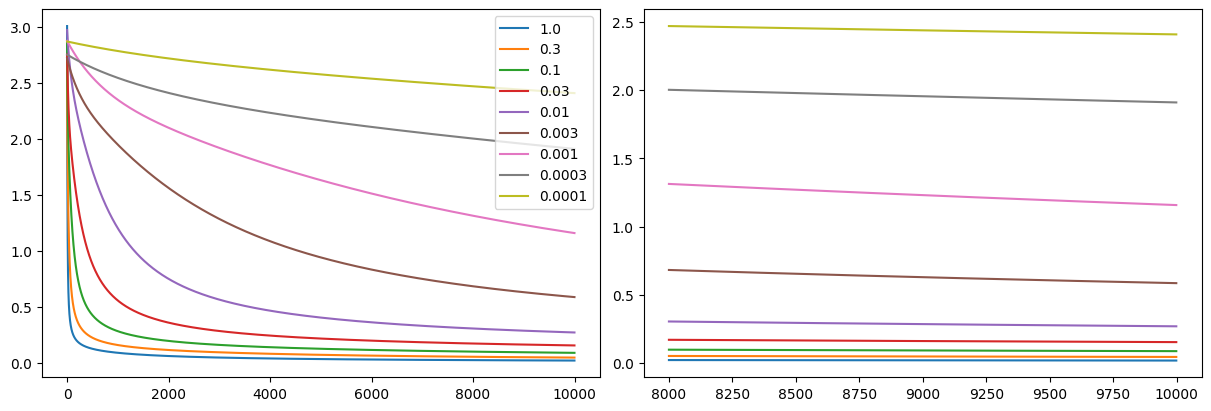

In [12]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 4))

for learning_rate in learning_rates:
    cost_history = cost_histories[learning_rate]
    ax1.plot(cost_history, label=learning_rate)
    ax2.plot(8000 + np.arange(len(cost_history[8000:])), cost_history[8000:])

ax1.legend()
plt.show()

In [13]:
best_learning_rate

0.1

In [14]:
sr = SoftmaxRegression(alpha=best_learning_rate, max_iters=10000)
sr.train(X_train, y_train)

In [15]:
sum(sr.predict(X_test) == y_test) / len(y_test)

0.9722222222222222

### sciKit-learn

In [16]:
from sklearn.metrics import accuracy_score

#### Logistic Regression Model

Let's now use scikit-learn's model for multinomial regression using softmax regression.

In [17]:
# Create the Softmax Regression model
lr = LogisticRegression(tol=1e-6, multi_class='multinomial', solver='lbfgs', max_iter=10000)

# Train the model
lr.fit(X_train, y_train)

LogisticRegression(max_iter=10000, multi_class='multinomial', tol=1e-06)

In [18]:
# Predict using the test set
y_pred = lr.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.975


#### SGD Classifier

Let's use the SGD classifier. Using the log loss tells the classifier to use logistic regression. Since we have multiple labels, softmax regression will be used.

In [19]:
from sklearn.linear_model import SGDClassifier

In [20]:
# Create the Softmax Regression model
sgd = SGDClassifier(tol=1e-6, loss='log_loss', alpha=0.0, learning_rate='constant', eta0=best_learning_rate, max_iter=10000)

# Train the model
sgd.fit(X_train, y_train)

SGDClassifier(alpha=0.0, eta0=0.1, learning_rate='constant', loss='log_loss',
              max_iter=10000, tol=1e-06)

In [21]:
# Predict using the test set
y_pred = sgd.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9777777777777777


All models' softmax regression performed well in classifying the digits we were given. Which may be expected since in the EDA, t-SNE showed 10 well-formed 2-D clusters.